In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression, SelectFromModel
from sklearn.linear_model import LassoCV, LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LogisticGAM
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
df = pd.read_csv('train.csv',sep=',')

univariate analyse

C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


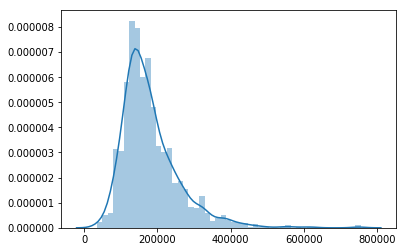

In [239]:
sns.distplot(y)

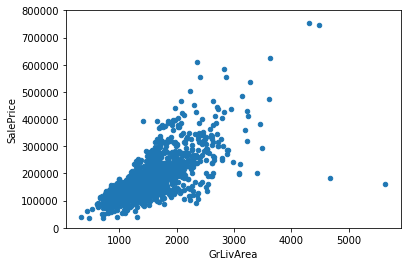

In [240]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([y, X[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

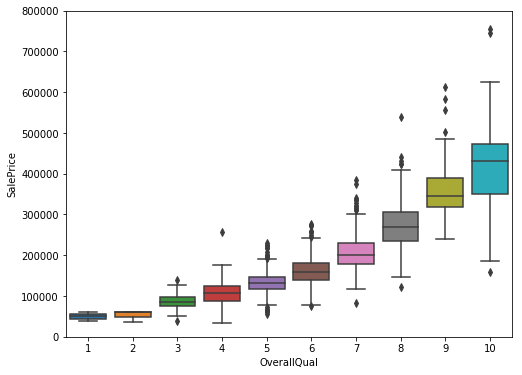

In [244]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([y, X[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

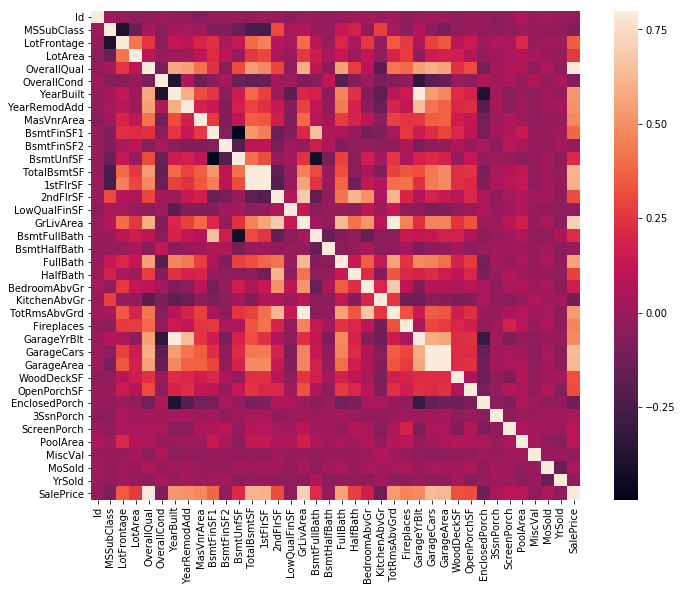

In [246]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

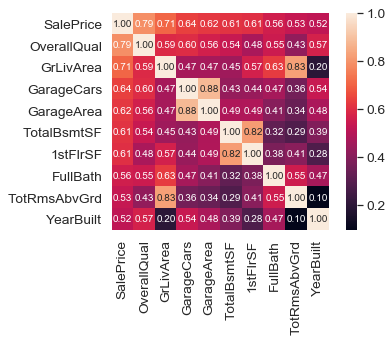

In [247]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

##Missing value

In [250]:
#missing data
# total = df_train.isnull().sum().sort_values(ascending=False)
# percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
# df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
# df_train.isnull().sum().max()

0

In [254]:
#df_train = df_train.drop(['1stFlrSF','GarageArea'],axis=1)

In [4]:
df_train = df
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

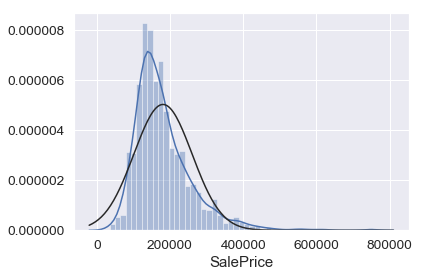

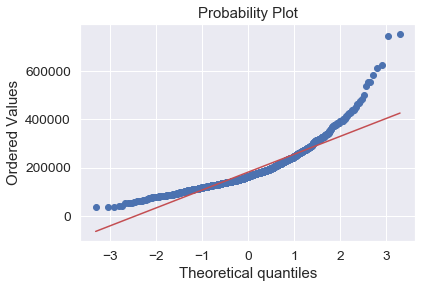

In [278]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

#in case of positive skewness, log transformations usually works well. 

In [5]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

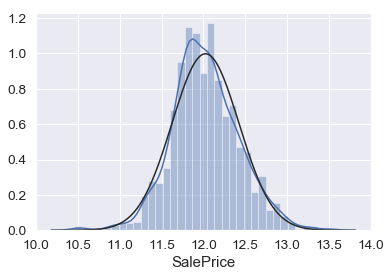

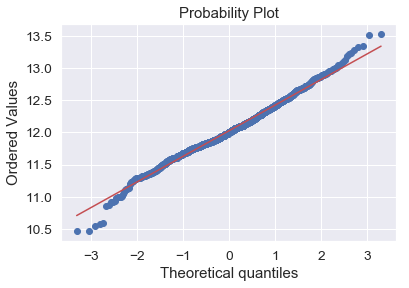

In [280]:
sns.distplot(df_train['SalePrice'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [6]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

In [7]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [8]:
#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


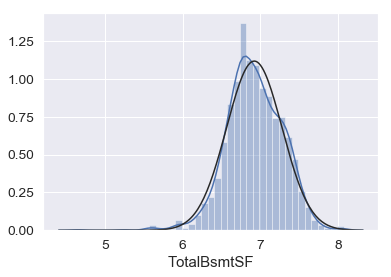

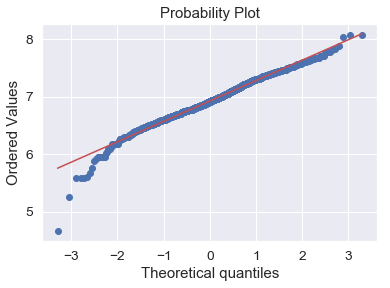

In [284]:
#histogram and normal probability plot (just for positive values)
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

In [9]:
df_train['MSSubClass'] = df_train['MSSubClass'].astype('object')

In [10]:
class FillbyGroup(BaseEstimator, TransformerMixin):
    def __init__(self, var_gp,var_to_fill):
        self.var_gp = var_gp
        self.var_to_fill = var_to_fill
        self.var_fill = None
    def fit(self, X, y=None):
        self.var_fill = X[self.var_to_fill].groupby(X[self.var_gp]).median()
        return self
    def transform(self, X, y=None):
        row = X[self.var_to_fill].isnull()
        X[self.var_to_fill][row] = X[self.var_gp][row].map(lambda neighbor: self.var_fill[neighbor])
        return X
    
        

In [11]:
fg = FillbyGroup(var_gp = 'Neighborhood', var_to_fill = 'LotFrontage')
df_train = fg.fit_transform(df_train)

C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [12]:
class FillData(BaseEstimator, TransformerMixin):
    def __init__(self, vars_na, vars_0, vars_freq):
        self.vars_na = vars_na
        self.vars_0 = vars_0
        self.vars_freq = vars_freq
        self.val_freq = None
        
    def fit(self, X, y=None):
        self.val_freq = [X[var_i].value_counts().idxmax() for var_i in self.vars_freq]
        return self
    
    def transform(self, X, y=None):
        X[self.vars_na] = X[self.vars_na].fillna('None')
        X[self.vars_0] = X[self.vars_0].fillna(0)
        for index, var_i in enumerate(self.vars_freq):
            X[var_i] = X[var_i].fillna(self.val_freq[index])
        return X
    
        

#Alley, MasVnrType,BamtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,PoolQC,MiscFeature,Fence,GarageCars =>None
#MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageArea =>0
#Electrical,MSZoning,Utilities,Exterior1st,Exterior2nd,KitchenQual,SaleType,Functional => frequent


In [13]:
fd = FillData(vars_na=['Alley', 'MasVnrType','BsmtQual','BsmtCond','BsmtExposure',\
                       'BsmtFinType1','BsmtFinType2','FireplaceQu',\
                       'PoolQC','MiscFeature','Fence','GarageCars','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond'],
              vars_0=['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'\
                      ,'TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageArea'], 
              vars_freq=['Electrical','MSZoning','Utilities','Exterior1st'\
                         ,'Exterior2nd','KitchenQual','SaleType','Functional'] )
df_train = fd.fit_transform(df_train)

In [14]:
df_train['GarageYrBlt'] = df_train.apply(lambda row : int(row['YearBuilt'])
                                                      if row['GarageYrBlt'] == 'None' else int(row['GarageYrBlt']),
                                                       axis=1)

In [15]:
def add5vars(X):
    X['total_sq_footage'] = X['GrLivArea'] + X['TotalBsmtSF'] 
    X['total_baths'] = X['BsmtFullBath'] + X['FullBath'] + (0.5 * (X['BsmtHalfBath'] + X['HalfBath']))
    # How many years has remoded from built
    X['RemodYears'] = X['YearRemodAdd'] - X['YearBuilt']
    # Did a remodeling happened from built?
    X["HasRemodeled"] = (X["YearRemodAdd"] != X["YearBuilt"]) * 1
    # Did a remodeling happen in the year the house was sold?
    X["HasRecentRemodel"] = (X["YearRemodAdd"] == X["YrSold"]) * 1
    return X

In [16]:
df_train_prep = add5vars(df_train)

In [17]:
class SelectItems(BaseEstimator, TransformerMixin):
    def __init__(self, type_select):
        self.type_select = type_select
        self.col_select = None
        
    def fit(self, X, y=None):
        assert(isinstance(X, pd.DataFrame))
        self.col_select = list(X.columns[X.dtypes == self.type_select])
        return self
    
    def transform(self, X, y=None):
        assert(isinstance(X, pd.DataFrame))
        return X[self.col_select]
    
        
        

In [19]:
class ImputeNa(BaseEstimator, TransformerMixin):
    def __init__(self,word_fill = 'NA'):
        self.word_fill = word_fill
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.word_fill)
        
        
        

In [20]:
class MultiLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.var = []
        self.var_cat = []
        self.label = []
    
    def fit(self, X, y=None):
        for i in X.columns:
            label_i = LabelEncoder()
            label_i.fit(X[[i]])
            label_i.classes_ = np.append(label_i.classes_, 'unknown')
            
            self.var.append(i)
            self.var_cat.append(label_i.classes_)
            self.label.append(label_i)
        return self
    
    def transform(self, X, y=None):
        
        res = []
        for index, var_i in enumerate(self.var):
            
            x = [i if i in self.var_cat[index] else 'unknown' for i in X[var_i]]
            
            res.append(pd.Series(self.label[index].transform(x)))
            
        return pd.concat(res,axis=1)
            
    

In [21]:
con_impute = Pipeline([ ('con_sel',SelectItems('float')),
                        ('impute_median', Imputer( strategy = 'median')),
                        ('scaler',StandardScaler()),
                      ])
int_impute = Pipeline([('con_sel',SelectItems('int64')),
                       ('impute_median',Imputer(strategy = 'median')),
                       ('scaler',StandardScaler()),    
                      ])
cat_impute = Pipeline([ ('cat_sel',SelectItems('object')),
                        ('impute_unknown',ImputeNa(word_fill='unknown')),
                        ('label', MultiLabelEncoder()),
                        ('onehot',OneHotEncoder(sparse=False,handle_unknown='ignore')),
                        #('acp', PCA(n_components=30)),                     
                      ])

#pca_t = PCA(n_components=30)
#pca_t1 = pca_t.fit_transform(df)
#np.cumsum(pca_t1.explained_variance_ratio_)
impute_part  = FeatureUnion([('con_part',con_impute),
                             ('int_part',int_impute),
                             ('cat_part',cat_impute)])

select_var = FeatureUnion([ ('best_reg', SelectKBest(f_regression, k=10)),
                            ('best_mutual',SelectKBest(mutual_info_regression, k=10)),
                            ('best_selectfromodel',SelectFromModel(LassoCV(cv=5),threshold=0.25))
             ])

prep = Pipeline([('impute_part',impute_part),
                 ('select_var',select_var),
])


In [22]:
X, y = df_train_prep.drop(['Id','SalePrice'],axis = 1), df_train_prep[['SalePrice']]
#X_new = impute_part.fit_transform(X,y)
X_new = impute_part.fit_transform(X)

C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\sklearn\prep

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=42, shuffle=True)

In [165]:
X_new_train = prep.fit_transform(X_train,y_train)
X_new_test = prep.transform(X_test)

C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\

In [24]:
rf = RandomForestRegressor(max_depth=3,n_estimators=500)
xgb = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500)
svr = LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=0, tol=1e-05, verbose=0)


In [26]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, 
                                   scoring='neg_mean_squared_error', n_jobs=4, cv=5, verbose=3, random_state=1001 )

In [27]:
random_search.fit(X_new, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [28]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [29]:
np.sqrt(abs(random_search.best_score_))

0.1349592965902026

In [30]:
y_pred = pd.DataFrame(random_search.best_estimator_.predict(X_new))

regr = LinearRegression()
regr.fit(y_pred,y)

#plt.scatter(y_pred, y, color='blue')
#plt.plot(y_pred, regr.predict(y_pred), color='red',linewidth=3)

residu = y.values - y_pred.values
#plt.scatter(y_pred, residu, color = 'blue')
residu_b = [1 if abs(i)>0.3 else 0 for i in residu ] 

In [649]:
X.dtypes

MSSubClass           object
MSZoning             object
LotFrontage         float64
LotArea               int64
Street               object
Alley                object
LotShape             object
LandContour          object
Utilities            object
LotConfig            object
LandSlope            object
Neighborhood         object
Condition1           object
Condition2           object
BldgType             object
HouseStyle           object
OverallQual           int64
OverallCond           int64
YearBuilt             int64
YearRemodAdd          int64
RoofStyle            object
RoofMatl             object
Exterior1st          object
Exterior2nd          object
MasVnrType           object
MasVnrArea          float64
ExterQual            object
ExterCond            object
Foundation           object
BsmtQual             object
                     ...   
Fireplaces            int64
FireplaceQu          object
GarageType           object
GarageYrBlt           int64
GarageFinish        

In [656]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [662]:

pvalue_var = dict()
for i_var in X.columns.tolist():
    print(i_var)
    gam = smf.ols(formula = 'residu_b ~ ')
    gam.fit(label.fit_transform(X[i_var].astype('category')),residu_b)
    pvalue_var.update({i_var: gam.statistics_['p_values'][0]})


MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch


C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\pygam\pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\pygam\pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(weights) >= np.sqrt(EPS)) * np.isfinite(weights)
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\pygam\pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *


ScreenPorch
PoolArea
PoolQC
Fence
MiscFeature
MiscVal
MoSold
YrSold
SaleType
SaleCondition
HasBsmt
total_sq_footage
total_baths
RemodYears
HasRemodeled
HasRecentRemodel


In [61]:
np.array(residu_b).reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [62]:
data=pd.DataFrame({'MSSubClass':X['MSSubClass'].values, 'residu_b':residu_b})
gam = sm.Logit(np.array(residu_b).reshape(-1,1), X[['MSSubClass']].values)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [46]:
gam.pvalues

Intercept               0.001605
C(MSSubClass)[T.30]     0.051618
C(MSSubClass)[T.40]     0.785622
C(MSSubClass)[T.45]     0.640032
C(MSSubClass)[T.50]     0.314360
C(MSSubClass)[T.60]     0.516578
C(MSSubClass)[T.70]     0.850567
C(MSSubClass)[T.75]     0.271180
C(MSSubClass)[T.80]     0.501753
C(MSSubClass)[T.85]     0.548929
C(MSSubClass)[T.90]     0.952832
C(MSSubClass)[T.120]    0.603394
C(MSSubClass)[T.160]    0.305480
C(MSSubClass)[T.180]    0.668875
C(MSSubClass)[T.190]    0.000066
dtype: float64

In [51]:
gam.

TypeError: 'Summary' object is not subscriptable

In [45]:
gam.summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               residu_b   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.911
Date:                Sun, 06 Jan 2019   Prob (F-statistic):             0.0216
Time:                        23:13:59   Log-Likelihood:                 701.70
No. Observations:                1458   AIC:                            -1373.
Df Residuals:                    1443   BIC:                            -1294.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0205      0.006      3.161      0.002       0.008       0.033
C(MSSubClass)[T.30]      0.0374      0.019      1.948      0.052      -0.000       0.075
C(MSSubClass)[T.40]     -0.0205      0.075     -0.272      0.786      -0.168       0.127
C(MSSubClass)[T.45]     -0.0205      0.044     -0.468      0.640      -0.107       0.066
C(MSSubClass)[T.50]      0.0142      0.014      1.006      0.314      -0.013       0.042
C(MSSubClass)[T.60]     -0.0071      0.011     -0.649      0.517      -0.028       0.014
C(MSSubClass)[T.70]     -0.0039      0.020     -0.188      0.851      -0.044       0.036
C(MSSubClass)[T.75]      0.0420      0.038      1.101      0.271      -0.033       0.117
C(MSSubClass)[T.80]      0.0140      0.021      0.672      0.502      -0.027       0.055
C(MSSubClass)[T.85]     -0.0205      0.034     -0.600      0.549      -0.088       0.047
C(MSSubClass)[T.90]     -0.0013      0.022     -0.059      0.953      -0.044       0.042
C(MSSubClass)[T.120]    -0.0090      0.017     -0.520      0.603      -0.043       0.025
C(MSSubClass)[T.160]    -0.0205      0.020     -1.025      0.305      -0.060       0.019
C(MSSubClass)[T.180]    -0.0205      0.048     -0.428      0.669      -0.115       0.074
C(MSSubClass)[T.190]     0.1128      0.028      4.000      0.000       0.057       0.168
==============================================================================
Omnibus:                     1683.805   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91359.785
Skew:                           6.156   Prob(JB):                         0.00
Kurtosis:                      39.773   Cond. No.                         19.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

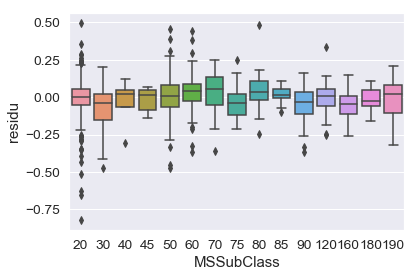

In [614]:
sns.boxplot(x='MSSubClass', y='residu', data=pd.DataFrame({'MSSubClass':X['MSSubClass'].values, 'residu':residu.reshape(-1)}))

In [539]:
rf.fit(X_train,y_train)
y_predict = rf.predict(X_test)

xgb.fit(X_train,y_train)
y_predict_xgb = xgb.predict(X_test)
y_predict_xgb_all = xgb.predict(X_new)

svr.fit(X_train,y_train)
y_predict_svr = svr.predict(X_test)

C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\Users\dkang\AppData\Local\Continuum\anaconda2\envs\env_tf\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [218]:
#xgb_cv = cross_val_score(xgb, X_new, np.log(y), cv = 3,scoring = 'neg_mean_squared_error',n_jobs = 4)

In [219]:
np.mean(np.sqrt(abs(xgb_cv)))

0.20461344727259298

In [542]:
np.sqrt(mean_squared_error(y_test, y_predict_xgb))

0.11592915316163767

In [ ]:
np.sqrt(mean_squared_error(y_test, y_predict))

In [537]:
np.sqrt(mean_squared_error(y_test,y_predict_svr))

0.12511781579864387

In [41]:
aaa = SelectItems('object')
df2 = aaa.fit_transform(X_train)
df2_test = aaa.transform(X_test)


In [49]:
df2_test.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
892,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,...,Attchd,RFn,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1105,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
413,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
522,RM,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Feedr,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1036,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [42]:

aa = ImputeNa(word_fill='unk')
df3 = aa.fit_transform(df2)
df4 = aa.transform(df2_test)

In [51]:
df4.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
892,RL,Pave,unk,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,...,Attchd,RFn,TA,TA,Y,unk,MnPrv,unk,WD,Normal
1105,RL,Pave,unk,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,unk,unk,unk,WD,Normal
413,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,Detchd,Unf,TA,TA,Y,unk,unk,unk,WD,Normal
522,RM,Pave,unk,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Feedr,...,Detchd,Unf,TA,TA,Y,unk,unk,unk,WD,Normal
1036,RL,Pave,unk,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,...,Attchd,Fin,TA,TA,Y,unk,unk,unk,WD,Normal


In [98]:
d = MultiLabelEncoder()
a = d.fit_transform(df3)
a_test = d.transform(df4)


In [101]:
t = OneHotEncoder(sparse=False)
dd = t.fit_transform(a)
#d2 = t.transform(a_test)

In [102]:
t.transform(a_test)

ValueError: unknown categorical feature present [ 6  5  7  6  6 14] during transform.

In [46]:
pd.DataFrame(dd).head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
